# Toss ML CTR 예측 모델링 파이프라인

## 개요
- **목표**: 광고 클릭률(CTR) 예측을 위한 이진 분류 모델 개발
- **데이터**: 10.7M 훈련 샘플, 119개 피처
- **접근법**: 딥러닝 기반 CTR 예측 모델

In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import gc
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import warnings
warnings.filterwarnings('ignore')

# CPU 및 멀티프로세싱 설정
CPU_COUNT = 8  # 사용 가능한 CPU 코어 수
OPTIMAL_WORKERS = min(CPU_COUNT - 1, 6)  # DataLoader용 (1개는 메인 프로세스용)
PROCESSING_WORKERS = CPU_COUNT  # 전처리용

# PyTorch 멀티스레딩 설정
torch.set_num_threads(CPU_COUNT)
os.environ['OMP_NUM_THREADS'] = str(CPU_COUNT)
os.environ['MKL_NUM_THREADS'] = str(CPU_COUNT)

print(f"CPU 코어 수: {CPU_COUNT}")
print(f"DataLoader workers: {OPTIMAL_WORKERS}")
print(f"Processing workers: {PROCESSING_WORKERS}")

# 시드 고정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# 설정
plt.style.use('default')
sns.set_palette("husl")

# 메모리 최적화 설정
MEMORY_LIMIT_GB = 100 
SAFETY_MARGIN = 0.95   
MAX_MEMORY_GB = MEMORY_LIMIT_GB * SAFETY_MARGIN

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Memory limit: {MAX_MEMORY_GB:.1f}GB")

CPU 코어 수: 8
DataLoader workers: 6
Processing workers: 8
PyTorch version: 2.3.0+cu121
CUDA available: True
Using device: cuda
Memory limit: 95.0GB


## 1. 데이터 로딩 및 탐색적 데이터 분석

In [3]:
# 데이터 로딩
print("데이터 로딩 중...")
train_df = pd.read_parquet("../data/raw/train.parquet", engine="pyarrow")
test_df = pd.read_parquet("../data/raw/test.parquet", engine="pyarrow").drop(columns=['ID'])
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

데이터 로딩 중...
Train shape: (10704179, 119)
Test shape: (1527298, 118)
Sample submission shape: (1527298, 2)


In [4]:
# 기본 정보 확인
print("=== 훈련 데이터 기본 정보 ===")
print(train_df.info())
print("\n=== 타겟 분포 ===")
print(train_df['clicked'].value_counts(normalize=True))

print("\n=== 결측값 확인 ===")
missing_info = train_df.isnull().sum()
print(f"결측값이 있는 컬럼 수: {(missing_info > 0).sum()}")
if (missing_info > 0).any():
    print(missing_info[missing_info > 0].head(10))

=== 훈련 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10704179 entries, 0 to 10704178
Columns: 119 entries, gender to clicked
dtypes: float32(112), int32(1), object(6)
memory usage: 5.0+ GB
None

=== 타겟 분포 ===
clicked
0    0.980925
1    0.019075
Name: proportion, dtype: float64

=== 결측값 확인 ===
결측값이 있는 컬럼 수: 96
gender       17208
age_group    17208
l_feat_2     17208
l_feat_8     17208
l_feat_18    17208
l_feat_19    17208
l_feat_20    17208
l_feat_21    17208
l_feat_22    17208
l_feat_23    17208
dtype: int64


In [5]:
# 피처 그룹별 분석
feature_groups = {
    'demographic': ['gender', 'age_group'],
    'contextual': ['inventory_id', 'day_of_week', 'hour', 'seq'],
    'l_feat': [col for col in train_df.columns if col.startswith('l_feat_')],
    'feat_e': [col for col in train_df.columns if col.startswith('feat_e_')],
    'feat_d': [col for col in train_df.columns if col.startswith('feat_d_')],
    'feat_c': [col for col in train_df.columns if col.startswith('feat_c_')],
    'feat_b': [col for col in train_df.columns if col.startswith('feat_b_')],
    'feat_a': [col for col in train_df.columns if col.startswith('feat_a_')],
    'history_a': [col for col in train_df.columns if col.startswith('history_a_')]
}

print("=== 피처 그룹별 개수 ===")
for group, features in feature_groups.items():
    print(f"{group}: {len(features)}개")

=== 피처 그룹별 개수 ===
demographic: 2개
contextual: 4개
l_feat: 27개
feat_e: 10개
feat_d: 6개
feat_c: 8개
feat_b: 6개
feat_a: 18개
history_a: 7개


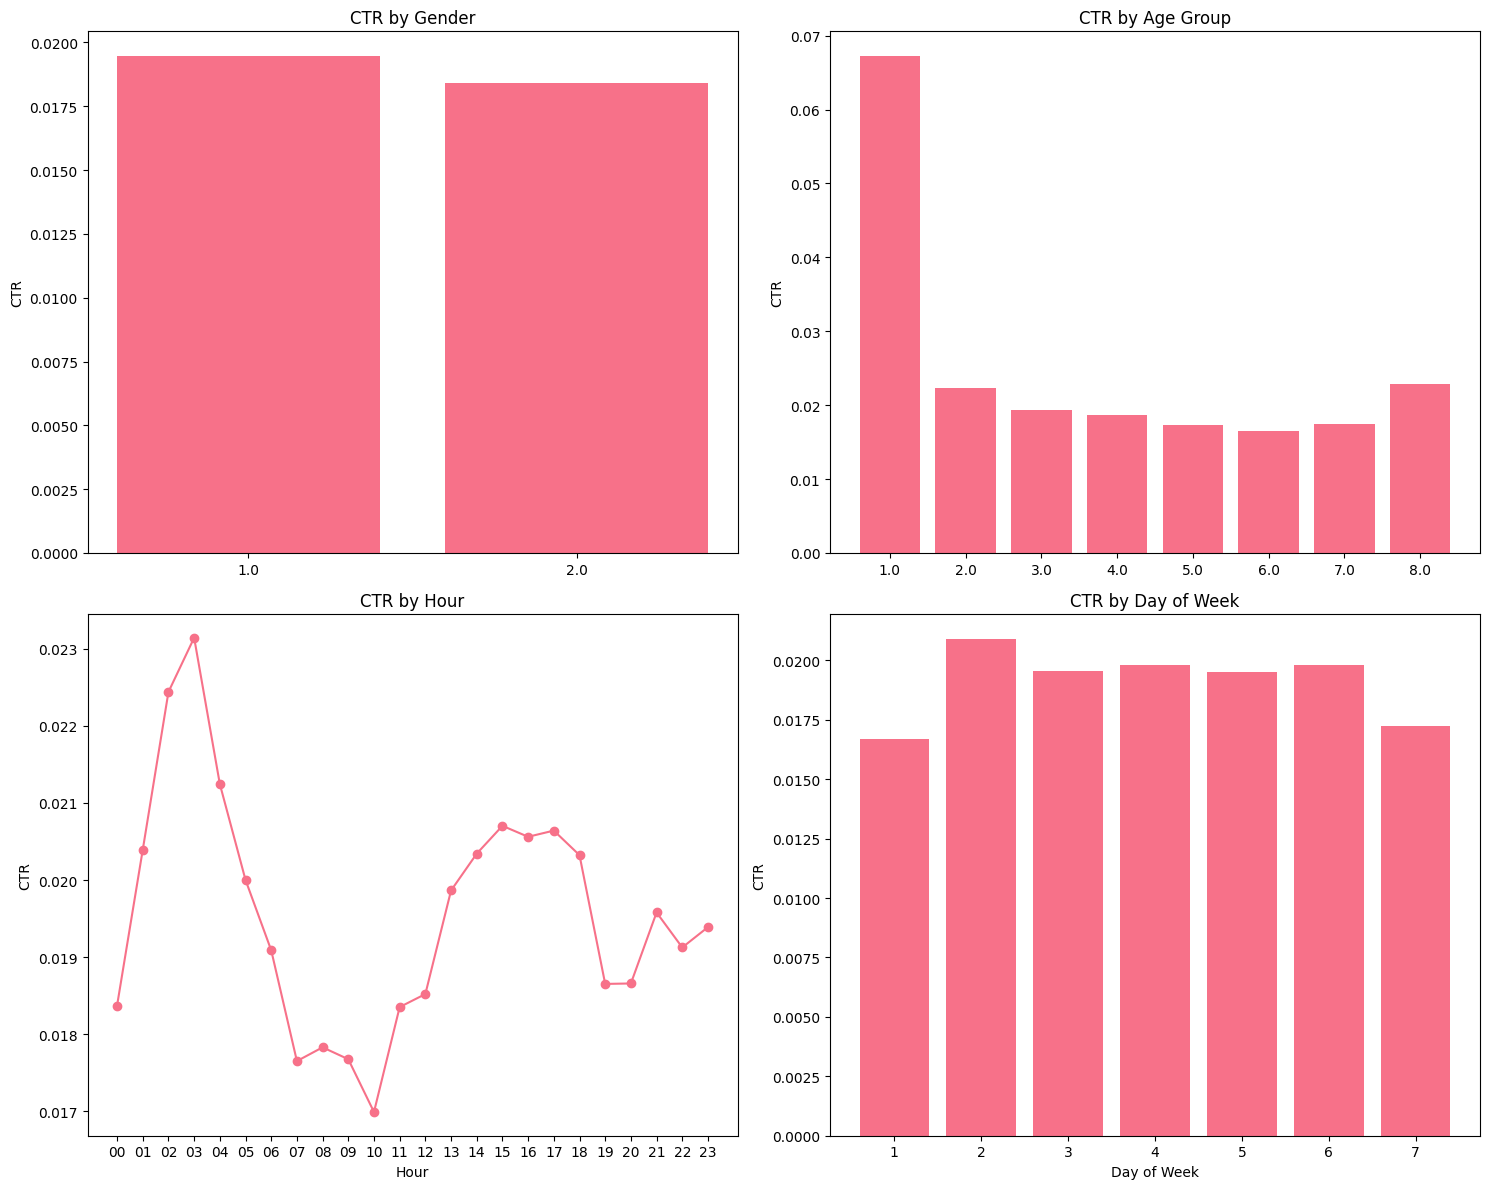

In [6]:
# 타겟과 주요 피처들 간의 관계 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 성별별 클릭률
gender_ctr = train_df.groupby('gender')['clicked'].agg(['count', 'mean'])
axes[0,0].bar(gender_ctr.index, gender_ctr['mean'])
axes[0,0].set_title('CTR by Gender')
axes[0,0].set_ylabel('CTR')

# 연령대별 클릭률
age_ctr = train_df.groupby('age_group')['clicked'].agg(['count', 'mean'])
axes[0,1].bar(age_ctr.index, age_ctr['mean'])
axes[0,1].set_title('CTR by Age Group')
axes[0,1].set_ylabel('CTR')

# 시간대별 클릭률
hour_ctr = train_df.groupby('hour')['clicked'].agg(['count', 'mean'])
axes[1,0].plot(hour_ctr.index, hour_ctr['mean'], marker='o')
axes[1,0].set_title('CTR by Hour')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('CTR')

# 요일별 클릭률
dow_ctr = train_df.groupby('day_of_week')['clicked'].agg(['count', 'mean'])
axes[1,1].bar(dow_ctr.index, dow_ctr['mean'])
axes[1,1].set_title('CTR by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('CTR')

plt.tight_layout()
plt.show()

## 2. 피처 엔지니어링 및 전처리

In [7]:
# 전역 함수들 (pickle 문제 해결을 위해)
def process_categorical_column_global(args):
    """범주형 컬럼 처리 함수 (전역 함수)"""
    col, values = args
    from sklearn.preprocessing import LabelEncoder
    
    # unique values 확인
    unique_values = values.value_counts().index.tolist()
    
    if len(unique_values) > 300:
        return col, None, None
    
    # 'missing' 클래스가 없으면 추가
    if 'missing' not in unique_values:
        unique_values.append('missing')
    
    le = LabelEncoder()
    le.fit(unique_values)
    encoded_values = le.transform(values)
    
    return col, encoded_values, le

def process_numerical_column_global(args):
    """수치형 컬럼 처리 함수 (전역 함수)"""
    col, data = args
    from sklearn.preprocessing import StandardScaler
    
    if data is not None:
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(data.fillna(0).values.reshape(-1, 1))
        return col, scaled_values.flatten(), scaler
    return col, None, None

class FeatureProcessor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.categorical_features = []
        self.numerical_features = []
        self.high_cardinality_features = []
        
    def identify_feature_types(self, df):
        """피처 타입 식별 - 멀티프로세싱 활용"""
        categorical_features = []
        numerical_features = []
        high_cardinality_features = []
        
        print("Analyzing feature types with CPU optimization...")
        
        # 컬럼들을 청크로 나눠서 병렬 처리
        columns = [col for col in df.columns if col not in ['clicked', 'ID']]
        
        def analyze_column(col):
            # 더 작은 샘플로 메모리 사용량 줄임
            sample_size = min(50000, len(df))
            sample_df = df[col].sample(n=sample_size, random_state=42)
            nunique_sample = sample_df.nunique()
            
            # 전체 unique 추정
            nunique_est = int(nunique_sample * (len(df) / sample_size))
            
            col_type = 'numerical'
            if df[col].dtype == 'object':
                if nunique_est > 300:
                    col_type = 'high_cardinality'
                else:
                    col_type = 'categorical'
            elif nunique_sample < 30:
                col_type = 'categorical'
            
            return col, col_type, nunique_est
        
        # ThreadPoolExecutor 사용 (ProcessPoolExecutor 대신)
        with ThreadPoolExecutor(max_workers=PROCESSING_WORKERS) as executor:
            results = list(executor.map(analyze_column, columns))
        
        for col, col_type, nunique_est in results:
            if col_type == 'high_cardinality':
                high_cardinality_features.append(col)
                print(f"High cardinality feature excluded: {col} (estimated unique: {nunique_est})")
            elif col_type == 'categorical':
                categorical_features.append(col)
            else:
                numerical_features.append(col)
                
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.high_cardinality_features = high_cardinality_features
        
        print(f"Categorical features: {len(categorical_features)}")
        print(f"Numerical features: {len(numerical_features)}")
        print(f"High cardinality features excluded: {len(high_cardinality_features)}")
        
        # 메모리 정리
        gc.collect()
        
    def fit_transform_categorical(self, df):
        """범주형 피처 인코딩 - ThreadPool 사용"""
        print("Processing categorical features with CPU optimization...")
        df_encoded = df.copy()
        
        # high cardinality features 제거
        for col in self.high_cardinality_features:
            if col in df_encoded.columns:
                df_encoded = df_encoded.drop(columns=[col])
                print(f"Dropped high cardinality feature: {col}")
        
        # ThreadPoolExecutor로 범주형 피처 처리 (더 안정적)
        categorical_args = []
        for col in self.categorical_features:
            if col in df.columns:
                values = df[col].astype(str).fillna('missing')
                categorical_args.append((col, values))
        
        print(f"Processing {len(categorical_args)} categorical features in parallel...")
        
        # ThreadPoolExecutor 사용 (pickle 문제 없음)
        with ThreadPoolExecutor(max_workers=min(PROCESSING_WORKERS, len(categorical_args))) as executor:
            results = list(executor.map(process_categorical_column_global, categorical_args))
        
        # 결과 적용
        for col, encoded_values, le in results:
            if encoded_values is not None:
                df_encoded[col] = encoded_values
                self.label_encoders[col] = le
                print(f"Processed {col}")
            else:
                print(f"Skipped {col}: too many unique values")
                if col in df_encoded.columns:
                    df_encoded = df_encoded.drop(columns=[col])
                
        return df_encoded
    
    def transform_categorical(self, df):
        """범주형 피처 인코딩 (transform only)"""
        df_encoded = df.copy()
        
        # high cardinality features 제거
        for col in self.high_cardinality_features:
            if col in df_encoded.columns:
                df_encoded = df_encoded.drop(columns=[col])
        
        for col in self.categorical_features:
            if col in df.columns and col in self.label_encoders:
                # 새로운 값들을 처리
                values = df[col].astype(str).fillna('missing')
                known_classes = set(self.label_encoders[col].classes_)
                values = values.apply(lambda x: x if x in known_classes else 'missing')
                df_encoded[col] = self.label_encoders[col].transform(values)
                
        return df_encoded
    
    def fit_transform_numerical(self, df):
        """수치형 피처 스케일링 - ThreadPool 사용"""
        print("Processing numerical features with CPU optimization...")
        df_scaled = df.copy()
        
        # ThreadPoolExecutor로 수치형 피처 처리
        numerical_args = []
        for col in self.numerical_features:
            if col in df.columns:
                numerical_args.append((col, df[col]))
        
        print(f"Processing {len(numerical_args)} numerical features in parallel...")
        
        with ThreadPoolExecutor(max_workers=PROCESSING_WORKERS) as executor:
            results = list(executor.map(process_numerical_column_global, numerical_args))
        
        # 결과 적용
        for col, scaled_values, scaler in results:
            if scaled_values is not None:
                df_scaled[col] = scaled_values
                self.scalers[col] = scaler
                
        return df_scaled
    
    def transform_numerical(self, df):
        """수치형 피처 스케일링 (transform only)"""
        df_scaled = df.copy()
        
        for col in self.numerical_features:
            if col in df.columns and col in self.scalers:
                df_scaled[col] = self.scalers[col].transform(df[[col]].fillna(0))
                
        return df_scaled

# 데이터 샘플링으로 메모리 사용량 조절
print("메모리 사용량을 최적화한 전처리 시작...")
print(f"원본 데이터 크기: {train_df.shape}")

# 메모리가 충분하지 않을 경우 데이터 샘플링
data_memory_estimate = train_df.memory_usage(deep=True).sum() / 1e9  # GB 단위
print(f"예상 데이터 메모리 사용량: {data_memory_estimate:.2f}GB")

if data_memory_estimate > MAX_MEMORY_GB * 0.6:  # 60% 이상이면 샘플링
    sample_ratio = (MAX_MEMORY_GB * 0.6) / data_memory_estimate
    sample_size = int(len(train_df) * sample_ratio)
    print(f"메모리 제한으로 데이터 샘플링: {sample_size:,} 샘플 ({sample_ratio:.2%})")
    
    # 층화 샘플링으로 타겟 비율 유지
    train_sampled = train_df.groupby('clicked', group_keys=False).apply(
        lambda x: x.sample(int(len(x) * sample_ratio), random_state=SEED)
    ).reset_index(drop=True)
else:
    train_sampled = train_df
    
print(f"최종 학습 데이터 크기: {train_sampled.shape}")

processor = FeatureProcessor()
processor.identify_feature_types(train_sampled)

print("\n훈련 데이터 전처리 시작...")
train_processed = processor.fit_transform_categorical(train_sampled)
print("범주형 피처 인코딩 완료")

train_processed = processor.fit_transform_numerical(train_processed)
print("수치형 피처 스케일링 완료")

print("\n테스트 데이터 전처리 시작...")
test_processed = processor.transform_categorical(test_df)
test_processed = processor.transform_numerical(test_processed)

print("\n전처리 완료!")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

# 원본 데이터 삭제로 메모리 확보
del train_df, test_df
if 'train_sampled' in locals():
    del train_sampled
gc.collect()

# 메모리 사용량 확인
print(f"현재 처리된 데이터 메모리 사용량: {train_processed.memory_usage(deep=True).sum() / 1e9:.2f}GB")

메모리 사용량을 최적화한 전처리 시작...
원본 데이터 크기: (10704179, 119)
예상 데이터 메모리 사용량: 29.77GB
최종 학습 데이터 크기: (10704179, 119)
Analyzing feature types with CPU optimization...
High cardinality feature excluded: gender (estimated unique: 428)
High cardinality feature excluded: age_group (estimated unique: 1712)
High cardinality feature excluded: inventory_id (estimated unique: 3853)
High cardinality feature excluded: day_of_week (estimated unique: 1498)
High cardinality feature excluded: hour (estimated unique: 5138)
High cardinality feature excluded: seq (estimated unique: 10586004)
Categorical features: 33
Numerical features: 79
High cardinality features excluded: 6

훈련 데이터 전처리 시작...
Processing categorical features with CPU optimization...
Dropped high cardinality feature: gender
Dropped high cardinality feature: age_group
Dropped high cardinality feature: inventory_id
Dropped high cardinality feature: day_of_week
Dropped high cardinality feature: hour
Dropped high cardinality feature: seq
Processing 33 ca

## 3. 딥러닝 모델 정의

In [11]:
class CTRDataset(Dataset):
    def __init__(self, features, targets=None):
        self.features = torch.FloatTensor(features.values)
        self.targets = torch.FloatTensor(targets.values) if targets is not None else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.targets is not None:
            return self.features[idx], self.targets[idx]
        return self.features[idx]

class DeepCTRModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(DeepCTRModel, self).__init__()
        
        # Input layer with batch normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Deep layers (크기를 줄여 메모리 사용량 감소: 512→256, 256→128, 128→64)
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
            
        self.deep_layers = nn.Sequential(*layers)
        
        # Output layer (sigmoid 제거)
        self.output = nn.Linear(prev_dim, 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.deep_layers(x)
        x = self.output(x)
        return x.squeeze()

# 모델 설정
feature_cols = [col for col in train_processed.columns if col not in ['clicked']]
input_dim = len(feature_cols)

print(f"Input dimension: {input_dim}")
print(f"Feature columns: {len(feature_cols)}")

# 메모리 추정 계산
def estimate_model_memory(input_dim, hidden_dims, batch_size):
    """모델 메모리 사용량 추정"""
    param_count = input_dim * hidden_dims[0]
    for i in range(len(hidden_dims)-1):
        param_count += hidden_dims[i] * hidden_dims[i+1]
    param_count += hidden_dims[-1]  # output layer
    
    # 파라미터 메모리 (float32 = 4 bytes)
    param_memory = param_count * 4 / 1e9  # GB
    
    # 배치 메모리 (forward + backward)
    batch_memory = batch_size * input_dim * 4 * 3 / 1e9  # GB (3x for forward, backward, optimizer)
    
    return param_memory, batch_memory, param_count

hidden_dims = [256, 128, 64]  # 줄어든 모델 크기
param_mem, batch_mem_4k, param_count = estimate_model_memory(input_dim, hidden_dims, 4096)
param_mem, batch_mem_1k, _ = estimate_model_memory(input_dim, hidden_dims, 1024)

print(f"\n=== 메모리 사용량 추정 ===")
print(f"모델 파라미터: {param_count:,}개")
print(f"파라미터 메모리: {param_mem:.2f}GB")
print(f"배치 메모리 (batch_size=4096): {batch_mem_4k:.2f}GB")
print(f"배치 메모리 (batch_size=1024): {batch_mem_1k:.2f}GB")
print(f"총 메모리 예상 (batch_size=1024): {param_mem + batch_mem_1k:.2f}GB")

Input dimension: 112
Feature columns: 112

=== 메모리 사용량 추정 ===
모델 파라미터: 69,696개
파라미터 메모리: 0.00GB
배치 메모리 (batch_size=4096): 0.01GB
배치 메모리 (batch_size=1024): 0.00GB
총 메모리 예상 (batch_size=1024): 0.00GB


## 4. 모델 훈련 및 검증

In [12]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.BCEWithLogitsLoss()  # BCELoss 대신 BCEWithLogitsLoss 사용
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    # Mixed Precision을 위한 GradScaler
    scaler = GradScaler()
    
    train_losses = []
    val_losses = []
    val_aucs = []
    
    best_val_auc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for i, (batch_features, batch_targets) in enumerate(train_loader):
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            optimizer.zero_grad()
            
            # Mixed Precision Training
            with autocast():
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
            
            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            # 메모리 정리 (매 100 배치마다)
            if i % 100 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
                
                # Mixed Precision Inference
                with autocast():
                    outputs = model(batch_features)
                    loss = criterion(outputs, batch_targets)
                
                val_loss += loss.item()
                # 시그모이드를 수동으로 적용하여 확률값 생성
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(batch_targets.cpu().numpy())
        
        # 메트릭 계산
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_auc = roc_auc_score(val_targets, val_preds)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        
        # Best model 저장
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
        
        scheduler.step(val_loss)
        
        # 에포크마다 메모리 정리
        torch.cuda.empty_cache()
        gc.collect()
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
    
    # Best model 로드
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs,
        'best_val_auc': best_val_auc
    }

In [13]:
# 데이터 분할
X = train_processed[feature_cols]
y = train_processed['clicked']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Train CTR: {y_train.mean():.4f}")
print(f"Validation CTR: {y_val.mean():.4f}")

# CPU와 메모리 기반 배치 사이즈 최적화
data_size_gb = train_processed.memory_usage(deep=True).sum() / 1e9
sample_count = len(X_train)

# CPU 코어 수를 고려한 배치 사이즈 계산
base_batch_size = 1024
cpu_multiplier = CPU_COUNT / 4  # 4코어 기준으로 스케일링
memory_factor = min(2.0, MAX_MEMORY_GB / 20)  # 20GB 기준

optimal_batch_size = int(base_batch_size * cpu_multiplier * memory_factor)

# 배치 사이즈 범위 제한
if data_size_gb > 15:
    optimal_batch_size = min(optimal_batch_size, 512)
elif data_size_gb > 10:
    optimal_batch_size = min(optimal_batch_size, 1024)
elif data_size_gb < 5:
    optimal_batch_size = min(optimal_batch_size, 4096)
else:
    optimal_batch_size = min(optimal_batch_size, 2048)

# 최소/최대 제한
optimal_batch_size = max(256, min(optimal_batch_size, 4096))

print(f"데이터 크기: {data_size_gb:.2f}GB")
print(f"샘플 수: {sample_count:,}")
print(f"CPU 기반 최적 배치 사이즈: {optimal_batch_size}")
print(f"예상 배치 수: {sample_count // optimal_batch_size}")

# CPU 효율성을 위한 DataLoader 설정
effective_workers = min(OPTIMAL_WORKERS, 6)  # DataLoader worker 수 제한
prefetch_factor = 2  # CPU가 많을 때 미리 로딩할 배치 수

print(f"DataLoader workers: {effective_workers}")
print(f"Prefetch factor: {prefetch_factor}")

# 데이터로더 생성 (CPU 최적화 설정)
train_dataset = CTRDataset(X_train, y_train)
val_dataset = CTRDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=True, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),  # GPU 사용 시만 활성화
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2,
    drop_last=True  # 마지막 배치 크기 일정하게 유지
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2,
    drop_last=False
)

# 모델 초기화
model = DeepCTRModel(input_dim=input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# CPU 및 메모리 사용량 추정
cpu_efficiency = (optimal_batch_size * effective_workers) / (CPU_COUNT * 1000)
total_estimated_memory = (
    train_processed.memory_usage(deep=True).sum() / 1e9 +  # 데이터
    sum(p.numel() for p in model.parameters()) * 4 / 1e9 +  # 모델
    optimal_batch_size * input_dim * 4 * 3 / 1e9 +  # 배치 처리
    effective_workers * optimal_batch_size * input_dim * 4 / 1e9  # Worker 버퍼
)

print(f"\n=== 리소스 사용량 예측 ===")
print(f"총 예상 메모리 사용량: {total_estimated_memory:.2f}GB")
print(f"CPU 효율성 지표: {cpu_efficiency:.3f}")
print(f"배치당 처리 샘플: {optimal_batch_size * effective_workers}")

if total_estimated_memory > MAX_MEMORY_GB:
    print(f"⚠️  예상 메모리 사용량이 제한({MAX_MEMORY_GB:.1f}GB)을 초과할 수 있습니다.")
    print("배치 사이즈나 워커 수를 줄이는 것을 권장합니다.")
else:
    print(f"✅ 메모리 사용량이 제한 내에 있습니다.")

print("\n훈련 시작...")

# 메모리 정리 후 훈련 시작
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

history = train_model(model, train_loader, val_loader, epochs=15, lr=0.001)

Train samples: 8563343
Validation samples: 2140836
Train CTR: 0.0191
Validation CTR: 0.0191
데이터 크기: 6.25GB
샘플 수: 8,563,343
CPU 기반 최적 배치 사이즈: 2048
예상 배치 수: 4181
DataLoader workers: 6
Prefetch factor: 2
Model parameters: 71,265

=== 리소스 사용량 예측 ===
총 예상 메모리 사용량: 6.26GB
CPU 효율성 지표: 1.536
배치당 처리 샘플: 12288
✅ 메모리 사용량이 제한 내에 있습니다.

훈련 시작...
Epoch 1/15 - Train Loss: 0.0975, Val Loss: 0.0893, Val AUC: 0.6878
Epoch 2/15 - Train Loss: 0.0909, Val Loss: 0.0892, Val AUC: 0.6900
Epoch 3/15 - Train Loss: 0.0901, Val Loss: 0.0891, Val AUC: 0.6927
Epoch 4/15 - Train Loss: 0.0898, Val Loss: 0.0892, Val AUC: 0.6936
Epoch 5/15 - Train Loss: 0.0896, Val Loss: 0.0891, Val AUC: 0.6948
Epoch 6/15 - Train Loss: 0.0895, Val Loss: 0.0890, Val AUC: 0.6960
Epoch 7/15 - Train Loss: 0.0895, Val Loss: 0.0889, Val AUC: 0.6967
Epoch 8/15 - Train Loss: 0.0895, Val Loss: 0.0889, Val AUC: 0.6976
Epoch 9/15 - Train Loss: 0.0895, Val Loss: 0.0889, Val AUC: 0.6966
Epoch 10/15 - Train Loss: 0.0894, Val Loss: 0.0894, Val AUC: 0

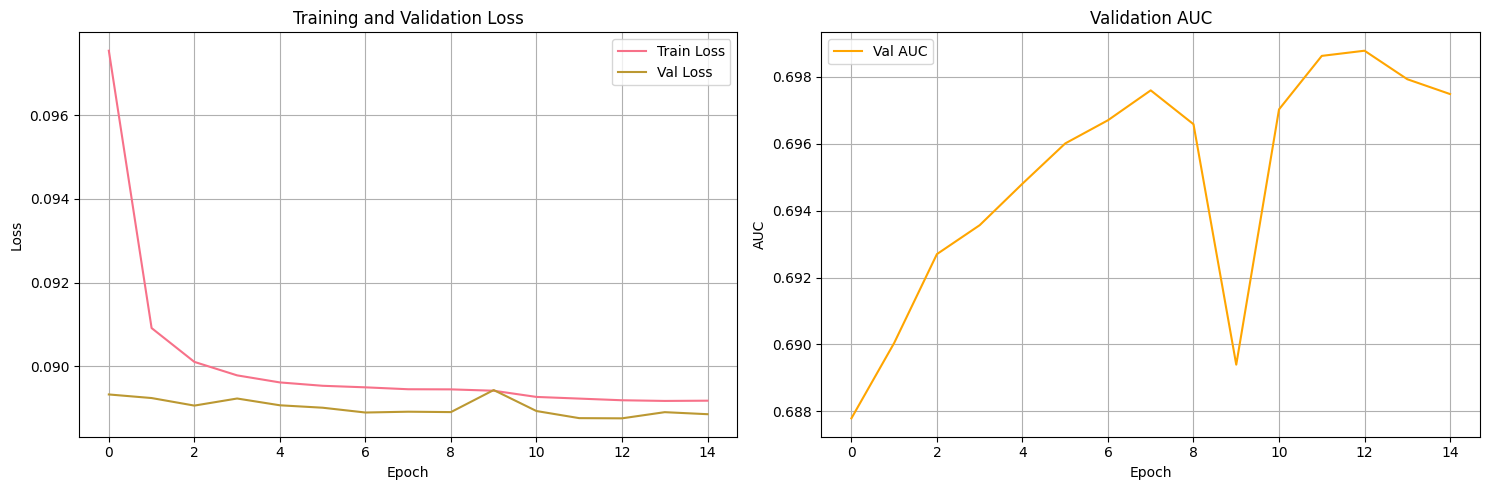


Best Validation AUC: 0.6988


In [14]:
# 훈련 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss 곡선
axes[0].plot(history['train_losses'], label='Train Loss')
axes[0].plot(history['val_losses'], label='Val Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# AUC 곡선
axes[1].plot(history['val_aucs'], label='Val AUC', color='orange')
axes[1].set_title('Validation AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Validation AUC: {history['best_val_auc']:.4f}")

## 5. 예측 및 제출 파일 생성

In [15]:
# 테스트 데이터 예측 (CPU 최적화)
model.eval()
test_features = test_processed[feature_cols]
test_dataset = CTRDataset(test_features)

# CPU 최적화된 예측용 DataLoader
test_loader = DataLoader(
    test_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2
)

test_predictions = []
total_batches = len(test_loader)

print("CPU 최적화된 테스트 데이터 예측 중...")
print(f"총 {total_batches} 배치, 배치 크기: {optimal_batch_size}")

with torch.no_grad():
    for i, batch_features in enumerate(test_loader):
        batch_features = batch_features.to(device, non_blocking=True)
        
        # Mixed Precision으로 예측
        with autocast():
            outputs = model(batch_features)
            # 시그모이드를 수동으로 적용하여 확률값 생성
            predictions = torch.sigmoid(outputs)
        
        test_predictions.extend(predictions.cpu().numpy())
        
        # 진행률 표시 (CPU 효율성 고려)
        if i % (total_batches // 10 + 1) == 0:
            progress = (i + 1) / total_batches * 100
            print(f"진행률: {progress:.1f}% ({i+1}/{total_batches})")
        
        # 메모리 정리 (CPU 최적화된 주기)
        if i % max(50, total_batches // 20) == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

# 최종 메모리 정리
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print(f"\n예측 완료! 총 {len(test_predictions)}개 샘플")
print(f"예측값 범위: [{min(test_predictions):.4f}, {max(test_predictions):.4f}]")
print(f"예측값 평균: {np.mean(test_predictions):.4f}")

# CPU 사용 통계
print(f"\n=== CPU 최적화 결과 ===")
print(f"사용된 Worker: {effective_workers}개")
print(f"배치당 샘플 수: {optimal_batch_size}")
print(f"총 처리량: {len(test_predictions)} 샘플")

CPU 최적화된 테스트 데이터 예측 중...
총 746 배치, 배치 크기: 2048
진행률: 0.1% (1/746)
진행률: 10.2% (76/746)
진행률: 20.2% (151/746)
진행률: 30.3% (226/746)
진행률: 40.3% (301/746)
진행률: 50.4% (376/746)
진행률: 60.5% (451/746)
진행률: 70.5% (526/746)
진행률: 80.6% (601/746)
진행률: 90.6% (676/746)

예측 완료! 총 1527298개 샘플
예측값 범위: [0.0002, 0.1248]
예측값 평균: 0.0189

=== CPU 최적화 결과 ===
사용된 Worker: 6개
배치당 샘플 수: 2048
총 처리량: 1527298 샘플


제출 파일 저장 완료: deep_ctr_submission.csv

=== 제출 파일 검증 ===
제출 파일 shape: (1527298, 2)
ID 중복 여부: False
예측값 범위: [0.0002, 0.1248]
예측값이 [0,1] 범위 내인지: True


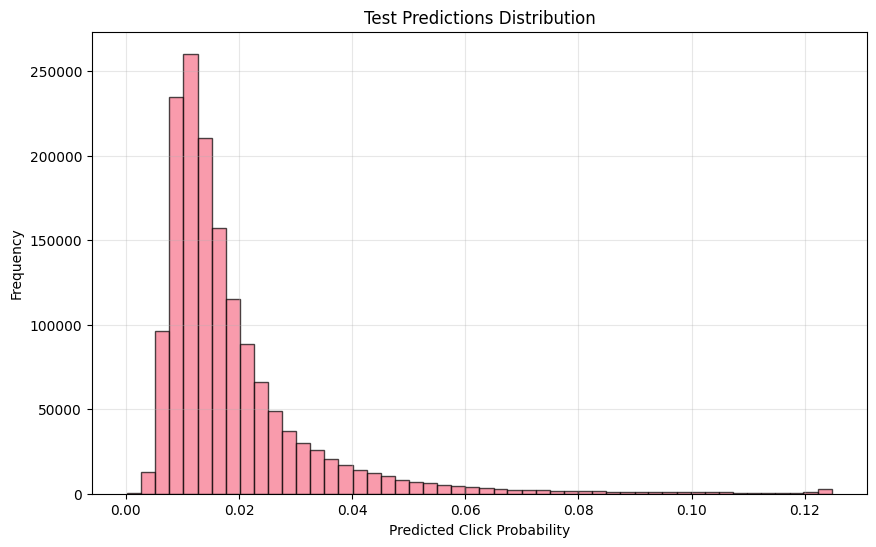

In [16]:
# 제출 파일 생성
submission = sample_submission.copy()
submission['clicked'] = test_predictions

# 제출 파일 저장
submission.to_csv('../outputs/deep_ctr_submission.csv', index=False)
print("제출 파일 저장 완료: deep_ctr_submission.csv")

# 제출 파일 검증
print("\n=== 제출 파일 검증 ===")
print(f"제출 파일 shape: {submission.shape}")
print(f"ID 중복 여부: {submission['ID'].duplicated().any()}")
print(f"예측값 범위: [{submission['clicked'].min():.4f}, {submission['clicked'].max():.4f}]")
print(f"예측값이 [0,1] 범위 내인지: {(submission['clicked'] >= 0).all() and (submission['clicked'] <= 1).all()}")

# 예측 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(submission['clicked'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Test Predictions Distribution')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 6. 모델 성능 분석 및 피처 중요도

=== 최종 검증 성능 ===
Validation AUC: 0.6975
Validation LogLoss: 0.0888


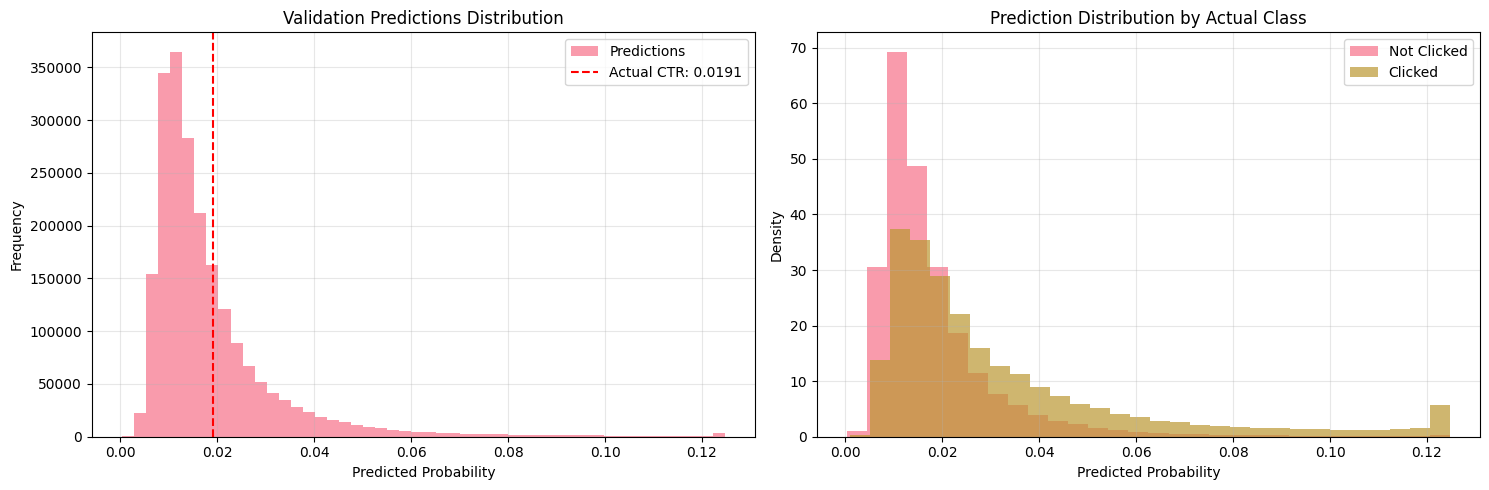

In [17]:
# 검증 데이터에 대한 상세 분석
model.eval()
with torch.no_grad():
    val_preds = []
    for batch_features, _ in val_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        # 시그모이드를 수동으로 적용하여 확률값 생성
        predictions = torch.sigmoid(outputs)
        val_preds.extend(predictions.cpu().numpy())

val_auc = roc_auc_score(y_val, val_preds)
val_logloss = log_loss(y_val, val_preds)

print("=== 최종 검증 성능 ===")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation LogLoss: {val_logloss:.4f}")

# 예측값 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 검증 데이터 예측 분포
axes[0].hist(val_preds, bins=50, alpha=0.7, label='Predictions')
axes[0].axvline(y_val.mean(), color='red', linestyle='--', label=f'Actual CTR: {y_val.mean():.4f}')
axes[0].set_title('Validation Predictions Distribution')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 클릭/비클릭별 예측값 분포
clicked_preds = [pred for pred, actual in zip(val_preds, y_val) if actual == 1]
not_clicked_preds = [pred for pred, actual in zip(val_preds, y_val) if actual == 0]

axes[1].hist(not_clicked_preds, bins=30, alpha=0.7, label='Not Clicked', density=True)
axes[1].hist(clicked_preds, bins=30, alpha=0.7, label='Clicked', density=True)
axes[1].set_title('Prediction Distribution by Actual Class')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# 모델 요약
print("\n" + "="*50)
print("              모델 훈련 완료!")
print("="*50)
print(f"📊 데이터셋 크기: {train_processed.shape[0]:,} 훈련 샘플, {test_processed.shape[0]:,} 테스트 샘플")
print(f"🔢 피처 수: {input_dim}개")
print(f"🎯 베스트 검증 AUC: {history['best_val_auc']:.4f}")
print(f"📈 최종 검증 AUC: {val_auc:.4f}")
print(f"📉 검증 LogLoss: {val_logloss:.4f}")
print(f"🎲 모델 파라미터: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}개")
print(f"💾 제출 파일: deep_ctr_submission.csv")
print("="*50)


              모델 훈련 완료!
📊 데이터셋 크기: 10,704,179 훈련 샘플, 1,527,298 테스트 샘플
🔢 피처 수: 112개
🎯 베스트 검증 AUC: 0.6988
📈 최종 검증 AUC: 0.6975
📉 검증 LogLoss: 0.0888
🎲 모델 파라미터: 71,265개
💾 제출 파일: deep_ctr_submission.csv
